In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import MultipleLocator
import os.path
from pathlib import Path
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from qbo1d import utils
from qbo1d import adsolver
from qbo1d import emulate
from qbo1d.stochastic_forcing import WaveSpectrum

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from qbo1d.stochastic_forcing import sample_sf_cw

%load_ext autoreload
%autoreload 2

## Utils

In [3]:
def ax_pos_inch_to_absolute(fig_size, ax_pos_inch):
    ax_pos_absolute = []
    ax_pos_absolute.append(ax_pos_inch[0]/fig_size[0])
    ax_pos_absolute.append(ax_pos_inch[1]/fig_size[1])
    ax_pos_absolute.append(ax_pos_inch[2]/fig_size[0])
    ax_pos_absolute.append(ax_pos_inch[3]/fig_size[1])
    
    return ax_pos_absolute

In [4]:
def plot_76_tensors(u, solver, amp25=None, amp20=None, period=None, isu=True):
    fig_size = (06.90, 02.20+01.50)
    fig = plt.figure(figsize=fig_size)

    ax = []

    ax.append(fig.add_axes(ax_pos_inch_to_absolute(fig_size, [00.75, 01.25, 06.00, 02.00])))

    cmin = -u.abs().max()
    cmax = u.abs().max()
    print(cmin)
    print(cmax)

    xmin = 84.
    xmax = 96.
    ymin = 17.
    ymax = 35.

    ax[0].set_xlim(left=84.)
    ax[0].set_xlim(right=96.)
    ax[0].set_ylim(bottom=17.)
    ax[0].set_ylim(top=35.)

    h = []

    h.append(ax[0].contourf(solver.time/86400/360, solver.z/1000, u.T,
                21, cmap="RdYlBu_r", vmin=cmin, vmax=cmax))

    
    ax[0].set_ylabel('Km', fontsize=10)

    ax[0].set_xlabel('model year', fontsize=10)

    # Set ticks
    xticks_list = np.arange(xmin, xmax+1, 1)
    ax[0].set_xticks(xticks_list)

    yticks_list = np.arange(ymin, ymax+2, 2)
    ax[0].set_yticks(yticks_list)

    xticklabels_list = list(xticks_list)
    xticklabels_list = [ '%.0f' % elem for elem in xticklabels_list ]
    ax[0].set_xticklabels(xticklabels_list, fontsize=10)

    ax[0].xaxis.set_minor_locator(MultipleLocator(1.))
    ax[0].yaxis.set_minor_locator(MultipleLocator(1.))

    ax[0].tick_params(which='both', left=True, right=True, bottom=True, top=True)
    ax[0].tick_params(which='both', labelbottom=True)

    # if u, the display \tau and \sigma
    if isu:
        ax[0].axhline(25., xmin=0, xmax=1, color='white', linestyle='dashed', linewidth=1.)
        ax[0].axhline(20., xmin=0, xmax=1, color='white', linestyle='dashed', linewidth=1.)

        ax[0].text(95.50, 25, r'$\sigma_{25}$ = ' '%.1f' %amp25 + r'$\mathrm{m s^{-1}}$',
        horizontalalignment='right', verticalalignment='bottom', color='black')

        ax[0].text(95.50, 20, r'$\sigma_{20}$ = ' '%.1f' %amp20 + r'$\mathrm{m s^{-1}}$',
        horizontalalignment='right', verticalalignment='bottom', color='black')

        ax[0].text(84.50, 25, r'$\tau_{25}$ = ' '%.0f' %period + 'months',
        horizontalalignment='left', verticalalignment='bottom', color='black')

    # The label it displays
    # u/s has different dimension
    if isu:
        label = r'$\mathrm{m s^{-1}}$'
    else:
        label = r'$\mathrm{m s^{-2}}$'
    
    # Color bars
    if isu:
        cbar_ax0 = fig.add_axes(ax_pos_inch_to_absolute(fig_size, [01.00, 00.50, 05.50, 00.10])) 
        ax[0].figure.colorbar(plt.cm.ScalarMappable(cmap="RdYlBu_r"), cax=cbar_ax0, format='% 2.0f', 
        boundaries=np.linspace(cmin, cmax, 21), orientation='horizontal',
        label=label)
    else:
        cbar_ax0 = fig.add_axes(ax_pos_inch_to_absolute(fig_size, [01.00, 00.50, 05.50, 00.10])) 
        ax[0].figure.colorbar(plt.cm.ScalarMappable(cmap="RdYlBu_r"), cax=cbar_ax0, format='% .2e', 
        boundaries=np.linspace(cmin, cmax, 11), orientation='horizontal',
        label=label)



In [5]:
def rMSE(s_gt, s_pred):
    error = (s_gt - s_pred)
    SSE = sum(error ** 2)
    MSE = SSE/s_gt.shape[0]
    RMSE = MSE**.5
    
    return RMSE
    
def mRMSE(s_gt, s_pred):
    return rMSE(s_gt, s_pred).mean()

def plot_MSE(RMSE_list):
    levels = list(range(len(RMSE_list[0])))
    for RMSE in RMSE_list:
        plt.scatter(x=RMSE, y=levels, s=2)
        plt.plot(RMSE, levels)
    plt.show()

# Solve the PDE using WaveSpectrum as the source function

In [2]:
# Load the data manually
# it takes 40 seconds

t_max = 360 * 108 * 86400
nsteps = 360 * 108
nspinup = 360 * 12
ntot = int(nsteps - nspinup)

torch.set_default_dtype(torch.float64)

# scenario 0 (control)
# --------------------
solver = adsolver.ADSolver(t_max=t_max, w=3e-4)
model = WaveSpectrum(solver)
time = solver.time
z = solver.z
u = solver.solve(source_func=model)

KeyboardInterrupt: 

In [46]:
# calculate amplitude and period
spinup_time = 12*360*86400

amp25 = utils.estimate_amplitude(solver.time, solver.z, u, height=25e3, spinup=spinup_time)
amp20 = utils.estimate_amplitude(solver.time, solver.z, u, height=20e3, spinup=spinup_time)
tau25 = utils.estimate_period(solver.time, solver.z, u, height=25e3, spinup=spinup_time)


## Visualization(Ground Truth)

### u(zonal wind)

tensor(-70.7526)
tensor(70.7526)


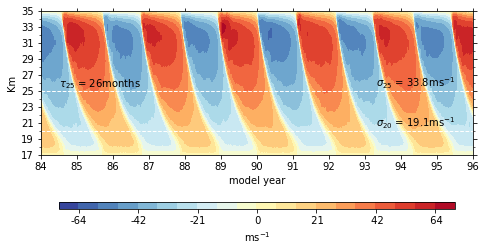

In [47]:
plot_76_tensors(u, solver=solver, amp25=amp25, amp20=amp20, period=tau25, isu=True)

### s (source function)

tensor(-0.0002)
tensor(0.0002)


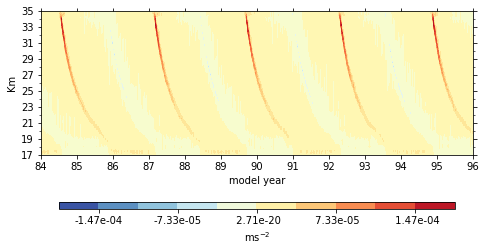

In [8]:
plot_76_tensors(model.s, solver, isu=False)

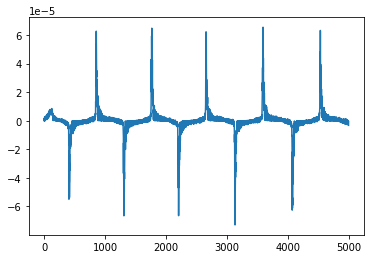

In [9]:
# visualization of level 35 
# time_step 0 - 5000

s_35 = model.s[:, 35]
plt.plot(list(range(len(s_35)))[:5000], s_35[:5000])

# Linear Regression on $(sf\cdot u)$

## Prepare for the data

In [10]:
# Load the data manually
# it takes 40 seconds

t_max = 360 * 108 * 86400
nsteps = 360 * 108
nspinup = 360 * 12
ntot = int(nsteps - nspinup)

torch.set_default_dtype(torch.float64)


# scenario 0 (control)
# --------------------
solver = adsolver.ADSolver(t_max=t_max, w=3e-4)
model = WaveSpectrum(solver)
time = solver.time
z = solver.z
u = solver.solve(source_func=model)
cw, sf = model.cw, model.sf

## scale by amplitude

* Here we want to try $A\cdot u$
* In the language of matrix, $u$ has shape (30000,76), $sf$ has shape (30000, )
* Also in the language of matrix, we can do $diag(sf) \cdot u$
* It takes a little bit longer then I expected since the matrix multiplication of more than 30000 dimensions takes long
* Want to see if there's some tricks that I could do


In [11]:
cw = cw[nspinup:nsteps]
sf = sf[nspinup:nsteps]
# print(sf.shape)
u = u[nspinup:nsteps, :]

s = model.s
s = s[nspinup:nsteps, :] 

U = torch.diag(sf) @ u
print(f"The shape of data U is {U.shape}")


# Here U is the features and s is the label

U_train, U_test, s_train, s_test = train_test_split(U, s, test_size=0.2, random_state=42)

The shape of data U is torch.Size([34560, 73])


In [12]:
# Though it may be clear to do the linear regression manually
# But the runtime of sklearn is optimal
reg = LinearRegression().fit(U_train, s_train)
prediction = reg.predict(U_test)
mean_l2_loss = np.linalg.norm((prediction - s_test.numpy()), axis=1).mean()
print(f"The loss of the linear regression: {mean_l2_loss}")
print(f"mRMSE: {mRMSE(prediction, s_test.numpy())}")
print(f"R-squared: {reg.score(U_test, s_test):.9f}")

The loss of the linear regression: 2.7917522819605338e-05
mRMSE: 3.6500667517290097e-06
R-squared: 0.892694510


* As we can see, the error increases a little bit

## ONLINE testing

In [13]:
torch.set_default_dtype(torch.float64)
solver_ML = adsolver.ADSolver(t_max=360*96*86400, w=3e-4)

# Set up the linear model to pass in the PDE

sf_ML, cw_ML = sample_sf_cw(solver_ML.time.shape[0], sfe=3.7e-3, sfv=1e-8, cwe=32, cwv=225, corr=0.75, seed=int(21*9+8))

model_ML_aug = lambda x : torch.tensor(reg.coef_) @ (sf_ML[solver_ML.current_step]*x) + torch.tensor(reg.intercept_)


u_ML = solver_ML.solve(source_func=model_ML_aug)
u_ML = u_ML.detach()

print("The UN - truncated u has length: ", len(u_ML))
nan_boolean = torch.tensor([not u_ML[i].isnan().any() for i in range(len(u_ML))]) # Boolean array to detect where u blows up
u_ML = u_ML[nan_boolean]
print("The truncated u has length: ", len(u_ML))

The UN - truncated u has length:  34561
The truncated u has length:  34561


In [14]:
spinup_time = 12*360*86400

amp25_ML = utils.estimate_amplitude(solver_ML.time, solver_ML.z, u_ML, height=25e3, spinup=spinup_time)
amp20_ML = utils.estimate_amplitude(solver_ML.time, solver_ML.z, u_ML, height=20e3, spinup=spinup_time)
tau25_ML = utils.estimate_period(solver_ML.time, solver_ML.z, u_ML, height=25e3, spinup=spinup_time)

In [15]:
# we need to calculate s_ML for further visualization
# this step is not that trivial this time
U_ML = torch.diag(sf_ML) @ u_ML
s_ML = torch.tensor(reg.predict(U_ML))

tensor(-1.9603e-05)
tensor(1.9603e-05)


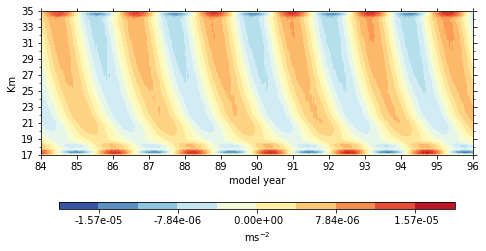

In [16]:
plot_76_tensors(s_ML, solver_ML, isu=False)

tensor(-62.1923)
tensor(62.1923)


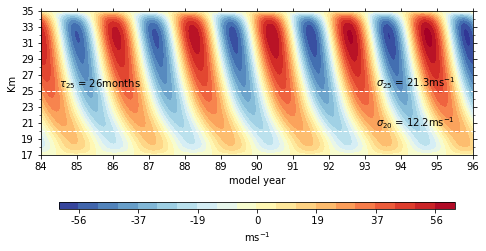

In [17]:
plot_76_tensors(u_ML, solver_ML, amp25=amp25_ML, amp20=amp20_ML, period=tau25_ML)

Text(0.5, 1.0, '$u_{z = 35}$ for $sfv = 1e-8$(Linear model based on $(u\\cdot sf)$)')

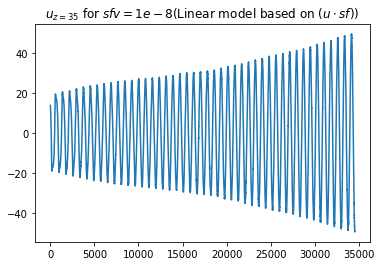

In [19]:
u_35 = u_ML[:, 40]
plt.plot(list(range(len(u_35))), u_35)
plt.title(r'$u_{z = 35}$ for $sfv = 1e-8$(Linear model based on $(u\cdot sf)$)')

* Outcome is better

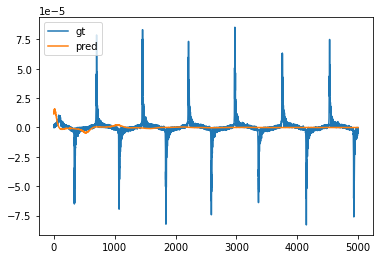

In [18]:
s_pred_35 = s_ML[:, 70]

plt.plot(list(range(len(model.s[:,35])))[:5000], model.s[:5000, 35], label="gt")
plt.plot(list(range(len(s_pred_35)))[:5000], s_pred_35[:5000], label="pred")


plt.legend()

## 

# Linear Regression on $(\frac{1}{sf}\cdot u)$

In [19]:
# Load the data manually
# it takes 40 seconds

t_max = 360 * 108 * 86400
nsteps = 360 * 108
nspinup = 360 * 12
ntot = int(nsteps - nspinup)

torch.set_default_dtype(torch.float64)


# scenario 0 (control)
# --------------------
solver = adsolver.ADSolver(t_max=t_max, w=3e-4)
model = WaveSpectrum(solver)
time = solver.time
z = solver.z
u = solver.solve(source_func=model)
cw, sf = model.cw, model.sf

In [20]:
cw = cw[nspinup:nsteps]
sf = sf[nspinup:nsteps]
print(sf.shape)
u = u[nspinup:nsteps, :]

s = model.s
s = s[nspinup:nsteps, :]

U = torch.diag(1/sf) @ u
print(f"The shape of data U is {U.shape}")


# Here U is the features and s is the label

U_train, U_test, s_train, s_test = train_test_split(U, s, test_size=0.2, random_state=42)

torch.Size([34560])
The shape of data U is torch.Size([34560, 73])


In [21]:
# Though it may be clear to do the linear regression manually
# But the runtime of sklearn is optimal
reg = LinearRegression().fit(U_train, s_train)
prediction = reg.predict(U_test)
mean_l2_loss = np.linalg.norm((prediction - s_test.numpy()), axis=1).mean()
print(f"The loss of the linear regression: {mean_l2_loss}")
print(f"mRMSE: {mRMSE(prediction, s_test.numpy())}")
print(f"R-squared: {reg.score(U_test, s_test):.9f}")

The loss of the linear regression: 2.7662757481783895e-05
mRMSE: 3.615481136097561e-06
R-squared: 0.897101474


In [22]:
torch.set_default_dtype(torch.float64)
solver_ML = adsolver.ADSolver(t_max=360*96*86400, w=3e-4)

# Set up the linear model to pass in the PDE

sf_ML, cw_ML = sample_sf_cw(solver_ML.time.shape[0], sfe=3.7e-3, sfv=1e-8, cwe=32, cwv=225, corr=0.75, seed=int(21*9+8))

model_ML_aug = lambda x : torch.tensor(reg.coef_) @ (x/sf_ML[solver_ML.current_step]) + torch.tensor(reg.intercept_)


u_ML = solver_ML.solve(source_func=model_ML_aug)
u_ML = u_ML.detach()

print("The UN - truncated u has length: ", len(u_ML))
nan_boolean = torch.tensor([not u_ML[i].isnan().any() for i in range(len(u_ML))]) # Boolean array to detect where u blows up
u_ML = u_ML[nan_boolean]
print("The truncated u has length: ", len(u_ML))

The UN - truncated u has length:  34561
The truncated u has length:  34561


In [23]:
spinup_time = 12*360*86400

amp25_ML = utils.estimate_amplitude(solver_ML.time, solver_ML.z, u_ML, height=25e3, spinup=spinup_time)
amp20_ML = utils.estimate_amplitude(solver_ML.time, solver_ML.z, u_ML, height=20e3, spinup=spinup_time)
tau25_ML = utils.estimate_period(solver_ML.time, solver_ML.z, u_ML, height=25e3, spinup=spinup_time)

In [24]:
# we need to calculate s_ML for further visualization
# this step is not that trivial this time
U_ML = torch.diag(1/sf_ML) @ u_ML
s_ML = torch.tensor(reg.predict(U_ML))

tensor(-1.9184e-05)
tensor(1.9184e-05)


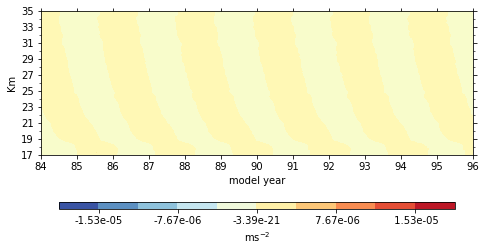

In [25]:
plot_76_tensors(s_ML, solver_ML, isu=False)

tensor(-25.4599)
tensor(25.4599)


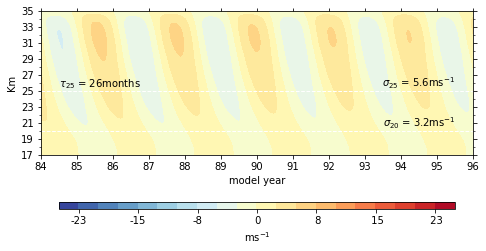

In [26]:
plot_76_tensors(u_ML, solver_ML, amp25=amp25_ML, amp20=amp20_ML, period=tau25_ML)

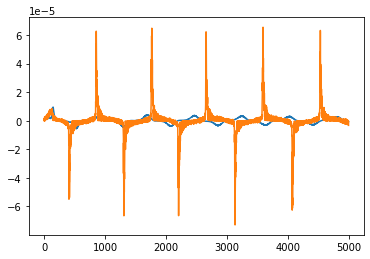

In [27]:
s_pred_35 = s_ML[:, 35]
plt.plot(list(range(len(s_pred_35)))[:5000], s_pred_35[:5000])
plt.plot(list(range(len(s_35)))[:5000], s_35[:5000])

# Try normalization

* I tried, it does not help

# Linear Regression on $(cw \cdot u)$

In [28]:
# Load the data manually
# it takes 40 seconds

t_max = 360 * 108 * 86400
nsteps = 360 * 108
nspinup = 360 * 12
ntot = int(nsteps - nspinup)

torch.set_default_dtype(torch.float64)


# scenario 0 (control)
# --------------------
solver = adsolver.ADSolver(t_max=t_max, w=3e-4)
model = WaveSpectrum(solver)
time = solver.time
z = solver.z
u = solver.solve(source_func=model)
cw, sf = model.cw, model.sf

KeyboardInterrupt: 

In [ ]:
cw = cw[nspinup:nsteps]
sf = sf[nspinup:nsteps]
u = u[nspinup:nsteps, :]

s = model.s
s = s[nspinup:nsteps, :]

U = torch.diag(cw) @ u
print(f"The shape of data U is {U.shape}")


# Here U is the features and s is the label

U_train, U_test, s_train, s_test = train_test_split(U, s, test_size=0.2, random_state=42)

The shape of data U is torch.Size([34560, 73])


In [ ]:
# Though it may be clear to do the linear regression manually
# But the runtime of sklearn is optimal
reg = LinearRegression().fit(U_train, s_train)
prediction = reg.predict(U_test)
mean_l2_loss = np.linalg.norm((prediction - s_test.numpy()), axis=1).mean()
print(f"The loss of the linear regression: {mean_l2_loss}")
print(f"rMSE: {mRMSE(prediction, s_test.numpy())}")
print(f"R-squared: {reg.score(U_test, s_test):.9f}")

The loss of the linear regression: 4.3686726735245565e-05
rMSE: 6.0683070438008885e-06
R-squared: 0.687325170


* Here we could see the R-squared is terrible

In [ ]:
torch.set_default_dtype(torch.float64)
solver_ML = adsolver.ADSolver(t_max=360*96*86400, w=3e-4)

# Set up the linear model to pass in the PDE

sf_ML, cw_ML = sample_sf_cw(solver_ML.time.shape[0], sfe=3.7e-3, sfv=1e-8, cwe=32, cwv=225, corr=0.75, seed=int(21*9+8))
 
model_ML_aug = lambda x : torch.tensor(reg.coef_) @ (x*cw_ML[solver_ML.current_step]) + torch.tensor(reg.intercept_)


u_ML = solver_ML.solve(source_func=model_ML_aug)
u_ML = u_ML.detach()

print("The UN - truncated u has length: ", len(u_ML))
nan_boolean = torch.tensor([not u_ML[i].isnan().any() for i in range(len(u_ML))]) # Boolean array to detect where u blows up
u_ML = u_ML[nan_boolean]
print("The truncated u has length: ", len(u_ML))

The UN - truncated u has length:  34561
The truncated u has length:  34561


In [ ]:
spinup_time = 12*360*86400

amp25_ML = utils.estimate_amplitude(solver_ML.time, solver_ML.z, u_ML, height=25e3, spinup=spinup_time)
amp20_ML = utils.estimate_amplitude(solver_ML.time, solver_ML.z, u_ML, height=20e3, spinup=spinup_time)
tau25_ML = utils.estimate_period(solver_ML.time, solver_ML.z, u_ML, height=25e3, spinup=spinup_time)

In [ ]:
amp20_ML

tensor(0.0335)

In [ ]:
print(f"period: {float(tau25_ML):.3f}")

period: 700.280
